In [1]:
# Importing libraries
import numpy as np
import astropy
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import pandas as pd
import math
import scipy
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
NSIDE=2048
Npix=12*NSIDE**2

pi=math.pi

In [2]:
pwd

'/home/maamari/Documents/USC_Cosmology'

In [3]:
# Reading maps
nilc_ymap = hp.read_map('COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
nilc_stddevmap = hp.read_map('COM_CompMap_Compton-SZMap-nilc-stddev_2048_R2.00.fits')
# Planck maps are in Galactic coordinates

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/maamari/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [4]:
# Smooth noise map by 1 degree
# The essential difference between Burenin and this, is that he uses
# a 1degree radius median filter for smoothing (not available on healpy)
stddev_smoothed = hp.smoothing(nilc_stddevmap,fwhm=np.radians(1.))

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [5]:
# Calculate signal over noise (smoothed)
sn_smoothed_n = nilc_ymap/stddev_smoothed

In [6]:
# Smooth the sn_smoothed_n map by 1 degree
sn_smoothed_n_smoothed = hp.smoothing(sn_smoothed_n,fwhm=np.radians(1.))

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [7]:
# Subtract the smoothed signal to noise map from the signal to noise map
sn_result = sn_smoothed_n - sn_smoothed_n_smoothed

In [8]:
# Mask the sn_result array
mask=hp.read_map('maskplanckfullsz61.fits')
sn_masked = hp.ma(sn_result)
sn_masked.mask = np.logical_not(mask)
# By convention the mask is 0 where the data are masked, while numpy defines data masked when 
# the mask is True, so it is necessary to flip the mask.

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


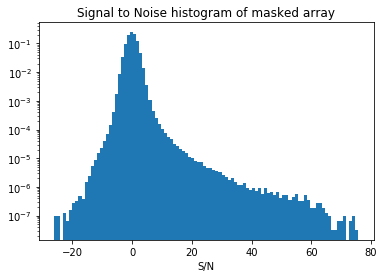

In [9]:
# Plot a histogram of the Signal to Noise masked map
# weights = np.ones_like(sn_masked.compressed())/len(sn_masked.compressed())
plt.hist(sn_masked.compressed(),bins=100,normed=True);
# plt.xlim((-20,20))
plt.yscale('log');
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of masked array');
plt.savefig('SN_dist_maskedarr.png')

In [10]:
# Define functions to convert l and b (RA,Dec converted to galactic coordinates) to pixel vals and vice versa
def blToIndex(b,l):
    return hp.ang2pix(NSIDE,np.deg2rad(90.0-b),np.deg2rad(l),lonlat=False,nest=False)
# Define a function to convert index to dec, ra
def IndexTobl(index):
    theta,phi=hp.pix2ang(NSIDE,index,lonlat=False,nest=False)
    return -np.degrees(theta-pi/2.),np.degrees(pi*2.-phi)
def blToIndex_8neighbors(b,l):
    return hp.get_all_neighbours(NSIDE,np.radians(90.0-b),np.radians(l),lonlat=False,nest=False)

In [11]:
# Load the Burenin Planck extended catalog
bur = np.loadtxt('planck_extended_burenin.dat')
bur_ra = pd.Series(bur[:,1],name='RA')
bur_dec = pd.Series(bur[:,2],name='Dec')
bur_sn = pd.Series(bur[:,4],name='SN')
df_bur = pd.concat([bur_dec,bur_ra,bur_sn],axis=1)
df_bur.head()

,Dec,RA,SN
0,29.1144,0.2000,4.58
1,21.5636,0.2958,7.77
2,-0.0147,0.3500,4.55
3,12.0578,0.5042,9.52
4,-1.0683,0.7042,4.99


In [12]:
c=SkyCoord(df_bur['RA'],df_bur['Dec'],frame='icrs',unit='deg')

In [13]:
c = c.galactic

In [14]:
df_bur['b'] = c.b.degree
df_bur['l'] = c.l.degree

In [15]:
df_bur.head()

,Dec,RA,SN,b,l
0,29.1144,0.2000,4.58,-32.464350,109.815588
1,21.5636,0.2958,7.77,-39.813384,107.662070
2,-0.0147,0.3500,4.55,-60.339963,96.974176
3,12.0578,0.5042,9.52,-49.020180,104.324479
4,-1.0683,0.7042,4.99,-61.448190,96.797899


In [16]:
# Get the pixel vals corresponding to the b,l values of Burenin clusters
bur_pixvals = blToIndex(df_bur['b'],df_bur['l'])

In [17]:
bur_sn_arr = np.zeros(Npix)
for i in bur_pixvals:
    bur_sn_arr[i] = sn_masked[i]

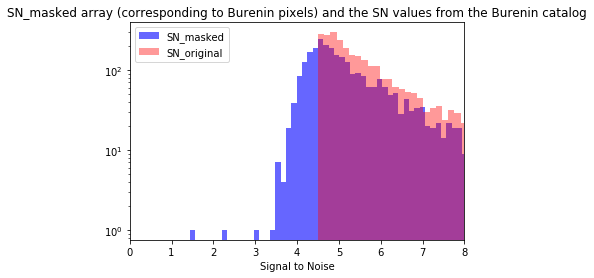

In [18]:
plt.hist(bur_sn_arr[bur_sn_arr>0],bins=500,color='b',label='SN_masked',alpha=0.6)
plt.hist(df_bur['SN'],bins=500,color='r',alpha=0.4,label='SN_original')
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('Signal to Noise')
plt.xlim((0,8))
plt.savefig('burenin_SN_distribution.png')
plt.title('SN_masked array (corresponding to Burenin pixels) and the SN values from the Burenin catalog');

In [19]:
len(bur_sn_arr[bur_sn_arr>4.0])

2882

In [20]:
stats.describe(bur_sn_arr)

DescribeResult(nobs=50331648, minmax=(0.0, 65.35806867025264), mean=0.0003542861164668128, variance=0.002860547581776152, skewness=293.5322770939905, kurtosis=182927.09462108972)

In [24]:
# Load the AMF DR9 main catalog
amfdr9 = np.genfromtxt('dr9_main_catalog.dat', dtype=float)
amfdr9_ra = pd.Series(amfdr9[:,3],name='RA')
amfdr9_dec = pd.Series(amfdr9[:,4],name='Dec')
df_amf = pd.concat([amfdr9_dec,amfdr9_ra],axis=1)
df_amf.head()

,Dec,RA
0,20.7465,23.9128
1,32.1398,260.6324
2,-1.3356,197.8796
3,46.6917,250.1485
4,21.0378,346.3402


In [25]:
c2=SkyCoord(df_amf['RA'],df_amf['Dec'],frame='icrs',unit='deg')
c2 = c2.galactic
df_amf['b'] = c2.b.degree
df_amf['l'] = c2.l.degree

In [26]:
df_amf.head()

,Dec,RA,b,l
0,20.7465,23.9128,-40.943468,136.662636
1,32.1398,260.6324,31.846666,55.602221
2,-1.3356,197.8796,61.128514,313.370385
3,46.6917,250.1485,41.429880,72.599428
4,21.0378,346.3402,-35.420653,92.175825


In [27]:
# Get the pixel vals corresponding to the b,l values of AMF clusters
amf_pixvals = blToIndex(df_amf['b'],df_amf['l'])

In [28]:
amf_sn_arr = np.zeros(Npix)
for i in amf_pixvals:
    amf_sn_arr[i] = sn_masked[i]

/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Warning: converting a masked element to nan.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
amf_sn_arr2 = np.zeros(Npix)
for i in amf_pixvals:
    amf_sn_arr2[i] = sn_result[i]

In [30]:
len(amf_sn_arr2[amf_sn_arr2>4.0])

1658

In [31]:
len(amf_sn_arr[amf_sn_arr>4.0])

/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


1534

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


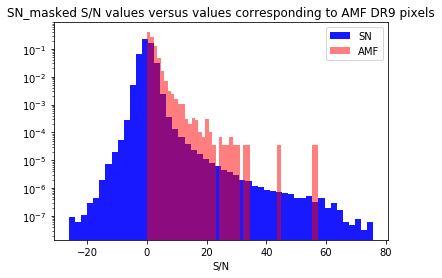

In [32]:
# Plot of sn_masked S/N values versus values corresponding to AMF DR9 pixels
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(amf_sn_arr[amf_sn_arr>0],bins=50,color='r',alpha=0.5,label='AMF',normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('S/N')
plt.title('SN_masked S/N values versus values corresponding to AMF DR9 pixels');
plt.savefig('snvals_maskedarr_amfdr9.png')

In [35]:
# Selecting AMF DR9 clusters richness > 50
amfrichcut = amfdr9[amfdr9[:,7]>50]
amfrichcut_ra = pd.Series(amfrichcut[:,3],name='RA')
amfrichcut_dec = pd.Series(amfrichcut[:,4],name='Dec')
df_amfrichcut = pd.concat([amfrichcut_dec,amfrichcut_ra],axis=1)
df_amfrichcut.head()

,Dec,RA
0,20.7465,23.9128
1,32.1398,260.6324
2,-1.3356,197.8796
3,46.6917,250.1485
4,21.0378,346.3402


In [36]:
c3=SkyCoord(df_amfrichcut['RA'],df_amfrichcut['Dec'],frame='icrs',unit='deg')
c3 = c3.galactic
df_amfrichcut['b'] = c3.b.degree
df_amfrichcut['l'] = c3.l.degree

In [37]:
df_amfrichcut.head()

,Dec,RA,b,l
0,20.7465,23.9128,-40.943468,136.662636
1,32.1398,260.6324,31.846666,55.602221
2,-1.3356,197.8796,61.128514,313.370385
3,46.6917,250.1485,41.429880,72.599428
4,21.0378,346.3402,-35.420653,92.175825


In [38]:
# Get the pixel vals corresponding to the b,l values of AMF clusters
amfrichcut_pixvals = blToIndex(df_amfrichcut['b'],df_amfrichcut['l'])

In [39]:
amfrichcut_sn_arr = np.zeros(Npix)
for i in amfrichcut_pixvals:
    amfrichcut_sn_arr[i] = sn_masked[i]

/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Warning: converting a masked element to nan.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
len(amf_sn_arr[amf_sn_arr>4.0])

/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


1534

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/maamari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


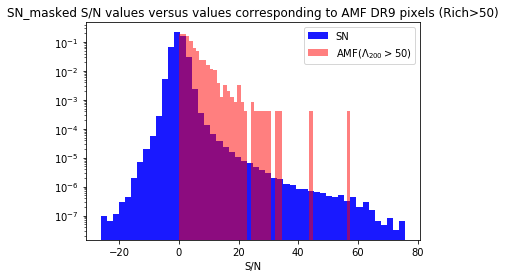

In [41]:
# Plot of sn_masked S/N values versus values corresponding to AMF DR9 pixels (cluster richness > 50)
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(amfrichcut_sn_arr[amfrichcut_sn_arr>0],bins=50,color='r',alpha=0.5,label='AMF($\Lambda_{200}>50$)',normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('S/N')
plt.title('SN_masked S/N values versus values corresponding to AMF DR9 pixels (Rich>50)');
plt.savefig('snvals_maskedarr_amfdr9richcut.png')

In [ ]:
# Load the redMaPPer catalog
red = np.loadtxt('redmapper2_v2.dat')
red_ra = pd.Series(red[:,1],name='RA')
red_dec = pd.Series(red[:,2],name='Dec')
df_red = pd.concat([red_dec,red_ra],axis=1)
df_red.head()

In [ ]:
c4=SkyCoord(df_red['RA'],df_red['Dec'],frame='icrs',unit='deg')
c4 = c4.galactic
df_red['b'] = c4.b.degree
df_red['l'] = c4.l.degree
df_red.head()

In [ ]:
# Get the pixel vals corresponding to the b,l values of redMaPPer clusters
red_pixvals = blToIndex(df_red['b'],df_red['l'])

In [ ]:
red_sn_arr = np.zeros(Npix)
for i in red_pixvals:
    red_sn_arr[i] = sn_masked[i]

In [ ]:
len(red_sn_arr[red_sn_arr>4.0])

In [ ]:
# Plot of sn_masked S/N values versus values corresponding to redMaPPer pixels 
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(red_sn_arr[red_sn_arr>0],bins=50,color='r',alpha=0.5,label='redMaPPer',normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('S/N')
plt.title('SN_masked S/N values versus values corresponding to redMaPPer pixels');
plt.savefig('snvals_maskedarr_red.png')

In [ ]:
redrichcut = red[red[:,4]>80]
redrichcut_ra = pd.Series(redrichcut[:,1],name='RA')
redrichcut_dec = pd.Series(redrichcut[:,2],name='Dec')
df_redrichcut = pd.concat([redrichcut_dec,redrichcut_ra],axis=1)
df_redrichcut.head()

In [ ]:
c5=SkyCoord(df_redrichcut['RA'],df_redrichcut['Dec'],frame='icrs',unit='deg')
c5 = c5.galactic
df_redrichcut['b'] = c5.b.degree
df_redrichcut['l'] = c5.l.degree
df_redrichcut.head()

In [ ]:
# Get the pixel vals corresponding to the b,l values of redMaPPer clusters
redrichcut_pixvals = blToIndex(df_redrichcut['b'],df_redrichcut['l'])

In [ ]:
redrichcut_sn_arr = np.zeros(Npix)
for i in redrichcut_pixvals:
    redrichcut_sn_arr[i] = sn_masked[i]

In [ ]:
# Plot of sn_masked S/N values versus values corresponding to redMaPPer pixels (Richness>80)
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(redrichcut_sn_arr[redrichcut_sn_arr>0],bins=50,color='r',alpha=0.5,label='redMaPPer (Rich>80)',normed=True)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('S/N')
plt.title('SN_masked S/N values versus values corresponding to redMaPPer pixels (Rich>80)');
plt.savefig('snvals_maskedarr_redrichcut.png')

In [ ]:
# Load the AMF DR9 ext catalog
amfext = np.loadtxt('/Users/pancham/Documents/Research/catalogs/dr9_extended_catalog.dat')
amfext_ra = pd.Series(amfext[:,1],name='RA')
amfext_dec = pd.Series(amfext[:,2],name='Dec')
df_amfext = pd.concat([amfext_dec,amfext_ra],axis=1)
df_amfext.head()

In [ ]:
c6=SkyCoord(df_amfext['RA'],df_amfext['Dec'],frame='icrs',unit='deg')
c6 = c6.galactic
df_amfext['b'] = c6.b.degree
df_amfext['l'] = c6.l.degree
df_amfext.head()

In [ ]:
# Get the pixel vals corresponding to the b,l values of AMF clusters
amfext_pixvals = blToIndex(df_amfext['b'],df_amfext['l'])

In [ ]:
amfext_sn_arr = np.zeros(Npix)
for i in amfext_pixvals:
    amfext_sn_arr[i] = sn_masked[i]

In [ ]:
pixlist_amfext_sngt4 = []
for i in amfext_pixvals:
    if (sn_masked[i]>4.0):
        pixlist_amfext_sngt4.append(i)

In [ ]:
len(pixlist_amfext_sngt4) #Why not 1886? Check!!

In [ ]:
amfext_sn_arr2 = np.zeros(Npix)
for i in amfext_pixvals:
    amfext_sn_arr2[i] = sn_result[i]

In [ ]:
pixlist_amfext_sngt4[:5]

In [ ]:
IndexTobl(11883761)

In [ ]:
b_l_amfext_sngt4 = IndexTobl(pixlist_amfext_sngt4)
b_amfext_sngt4 = b_l_amfext_sngt4[0] 
l_amfext_sngt4 = b_l_amfext_sngt4[1]
c13 = SkyCoord('galactic',l=l_amfext_sngt4,b=b_amfext_sngt4,unit='deg')
amfext_sngt4_ra = pd.Series(c13.fk5.ra.degree,name='RA')
amfext_sngt4_dec = pd.Series(c13.fk5.dec.degree,name='Dec')
amfext_sngt4_ra_dec = pd.concat([amfext_sngt4_ra,amfext_sngt4_dec],axis=1)
amfext_sngt4_ra_dec.head()


In [ ]:
amfext_sngt4_ra_dec.to_csv('amfext_sngt4_ra_dec.dat')

In [ ]:
len(amfext_sn_arr2[amfext_sn_arr2>4])

In [ ]:
len(amfext_sn_arr[amfext_sn_arr>4])

In [ ]:
# The Planck SZ2 catalog
planck = np.loadtxt('/Users/pancham/Documents/Research/catalogs/planck_v5.dat')
pl_ra = pd.Series(planck[:,1],name='RA')
pl_dec = pd.Series(planck[:,2],name='Dec')
pl_y = pd.Series(planck[:,3],name='Y')
df_pl = pd.concat([pl_dec,pl_ra,pl_y],axis=1)
df_pl.head()

In [ ]:
c7=SkyCoord(df_pl['RA'],df_pl['Dec'],frame='icrs',unit='deg')
c7 = c7.galactic
df_pl['b'] = c7.b.degree
df_pl['l'] = c7.l.degree
df_pl.head()

In [ ]:
# Get the pixel vals corresponding to the b,l values of Planck clusters
pl_pixvals = blToIndex(df_pl['b'],df_pl['l'])

In [ ]:
len(list(set(amfext_pixvals) & set(pl_pixvals)))

In [ ]:
pl_sn_arr = np.zeros(Npix)
for i in pl_pixvals:
    pl_sn_arr[i] = sn_masked[i]

In [ ]:
len(pl_sn_arr[pl_sn_arr>0])

In [ ]:
pl_8pixvals = blToIndex_8neighbors(df_pl['b'],df_pl['l'])
amf_8pixvals = blToIndex_8neighbors(df_pl['b'],df_pl['l'])

In [ ]:
pl_8pixvals.shape

In [ ]:
# With a 10 arc minradius, amf dr9 extended matches 511 Planck clusters
# Import these in and see how many lie in the mask


pl_amfextmatch_10arcmin = np.loadtxt('/Users/pancham/Documents/Research/catalogs/planck_amfext_match_10arcmin.dat')
pl_amfextmatch_10arcmin_ra = pd.Series(pl_amfextmatch_10arcmin[:,1],name='RA')
pl_amfextmatch_10arcmin_dec = pd.Series(pl_amfextmatch_10arcmin[:,2],name='Dec')
df_pl_amfextmatch_10arcmin = pd.concat([pl_amfextmatch_10arcmin_dec,pl_amfextmatch_10arcmin_ra],axis=1)
df_pl_amfextmatch_10arcmin.head()

In [ ]:
c8=SkyCoord(df_pl_amfextmatch_10arcmin['RA'],df_pl_amfextmatch_10arcmin['Dec'],frame='icrs',unit='deg')
c8 = c8.galactic
df_pl_amfextmatch_10arcmin['b'] = c8.b.degree
df_pl_amfextmatch_10arcmin['l'] = c8.l.degree
df_pl_amfextmatch_10arcmin.head()

In [ ]:
pl_amfext_10arcmin_pixvals = blToIndex(df_pl_amfextmatch_10arcmin['b'],df_pl_amfextmatch_10arcmin['l'])

In [ ]:
len(pl_amfext_10arcmin_pixvals)

In [ ]:
pl_amfext_10arcmin_sn_arr = np.zeros(Npix)
for i in pl_amfext_10arcmin_pixvals:
    pl_amfext_10arcmin_sn_arr[i] = sn_masked[i]

In [ ]:
len(pl_amfext_10arcmin_sn_arr[pl_amfext_10arcmin_sn_arr>4.0])

In [ ]:
# With a 5 arc minradius, amf dr9 extended matches 413 Planck clusters
# Import these in and see how many lie in the mask


pl_amfextmatch_5arcmin = np.loadtxt('/Users/pancham/Documents/Research/catalogs/planck_amfext_match_5arcmin.dat')
pl_amfextmatch_5arcmin_ra = pd.Series(pl_amfextmatch_5arcmin[:,1],name='RA')
pl_amfextmatch_5arcmin_dec = pd.Series(pl_amfextmatch_5arcmin[:,2],name='Dec')
df_pl_amfextmatch_5arcmin = pd.concat([pl_amfextmatch_5arcmin_dec,pl_amfextmatch_5arcmin_ra],axis=1)
df_pl_amfextmatch_5arcmin.head()

In [ ]:
c9=SkyCoord(df_pl_amfextmatch_5arcmin['RA'],df_pl_amfextmatch_5arcmin['Dec'],frame='icrs',unit='deg')
c9 = c9.galactic
df_pl_amfextmatch_5arcmin['b'] = c9.b.degree
df_pl_amfextmatch_5arcmin['l'] = c9.l.degree
df_pl_amfextmatch_5arcmin.head()

In [ ]:
pl_amfext_5arcmin_pixvals = blToIndex(df_pl_amfextmatch_5arcmin['b'],df_pl_amfextmatch_5arcmin['l'])

In [ ]:
pl_amfext_5arcmin_sn_arr = np.zeros(Npix)
for i in pl_amfext_5arcmin_pixvals:
    pl_amfext_5arcmin_sn_arr[i] = sn_masked[i]

In [ ]:
len(pl_amfext_5arcmin_sn_arr[pl_amfext_5arcmin_sn_arr>4.0])

In [ ]:
# With a 10 arc minradius, amf dr9 main matches 485 Planck clusters
# Import these in and see how many lie in the mask


pl_amf_10arcmin = np.loadtxt('/Users/pancham/Documents/Research/catalogs/planck_amf_match_10arcmin.dat')
pl_amf_10arcmin_ra = pd.Series(pl_amf_10arcmin[:,1],name='RA')
pl_amf_10arcmin_dec = pd.Series(pl_amf_10arcmin[:,2],name='Dec')
df_pl_amf_10arcmin = pd.concat([pl_amf_10arcmin_dec,pl_amf_10arcmin_ra],axis=1)
df_pl_amf_10arcmin.head()

In [ ]:
c10=SkyCoord(df_pl_amf_10arcmin['RA'],df_pl_amf_10arcmin['Dec'],frame='icrs',unit='deg')
c10 = c10.galactic
df_pl_amf_10arcmin['b'] = c10.b.degree
df_pl_amf_10arcmin['l'] = c10.l.degree
df_pl_amf_10arcmin.head()

In [ ]:
pl_amf_10arcmin_pixvals = blToIndex(df_pl_amf_10arcmin['b'],df_pl_amf_10arcmin['l'])

In [ ]:
pl_amf_10arcmin_sn_arr = np.zeros(Npix)
for i in pl_amf_10arcmin_pixvals:
    pl_amf_10arcmin_sn_arr[i] = sn_masked[i]

In [ ]:
len(pl_amf_10arcmin_sn_arr[pl_amf_10arcmin_sn_arr>4.0])

In [ ]:
# With a 5 arc minradius, amf dr9 main matches 397 Planck clusters
# Import these in and see how many lie in the mask


pl_amf_5arcmin = np.loadtxt('/Users/pancham/Documents/Research/catalogs/planck_amf_match_5arcmin.dat')
pl_amf_5arcmin_ra = pd.Series(pl_amf_5arcmin[:,1],name='RA')
pl_amf_5arcmin_dec = pd.Series(pl_amf_5arcmin[:,2],name='Dec')
df_pl_amf_5arcmin = pd.concat([pl_amf_5arcmin_dec,pl_amf_5arcmin_ra],axis=1)
df_pl_amf_5arcmin.head()

In [ ]:
c11=SkyCoord(df_pl_amf_5arcmin['RA'],df_pl_amf_5arcmin['Dec'],frame='icrs',unit='deg')
c11 = c11.galactic
df_pl_amf_5arcmin['b'] = c11.b.degree
df_pl_amf_5arcmin['l'] = c11.l.degree
df_pl_amf_5arcmin.head()

In [ ]:
pl_amf_5arcmin_pixvals = blToIndex(df_pl_amf_5arcmin['b'],df_pl_amf_5arcmin['l'])

In [ ]:
pl_amf_5arcmin_sn_arr = np.zeros(Npix)
for i in pl_amf_5arcmin_pixvals:
    pl_amf_5arcmin_sn_arr[i] = sn_masked[i]

In [ ]:
len(pl_amf_5arcmin_sn_arr[pl_amf_5arcmin_sn_arr>4.0])

In [ ]:
len(pl_amf_5arcmin_sn_arr)

In [ ]:
len(amfext_sn_arr)

In [ ]:
lst1 = list(pl_amf_5arcmin_pixvals)

In [ ]:
lst2 = list(pixlist_amfext_sngt4)

In [ ]:
lst3 = [x for x in lst2 if x in lst1]

In [ ]:
len(lst3) #Might be too strict, we want to match positions in ra,dec or b,l, not pixvals

In [ ]:
lst4 = hp.get_all_neighbours(2048,pixlist_amfext_sngt4)
#lst5 = hp.get_all_neighbours(2048,pl_amf_5arcmin_pixvals)
lst5 = pl_amf_5arcmin_pixvals


In [ ]:
set4 = set(list(np.reshape(lst4,(16176,))))
set5 = set(lst5)

In [ ]:
len(set4 & set5)

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord,Galactic,FK5
from astropy.table import Table

In [ ]:
len(pixlist_amfext_sngt4)

In [ ]:
pixlist_amfext_sngt4[:5]

In [ ]:
amfext_bvals = IndexTobl(pixlist_amfext_sngt4)[0] #This gives the b,l of the index val, we want to convert this to RA,Dec
amfext_lvals = IndexTobl(pixlist_amfext_sngt4)[1]



In [ ]:
amfext_bvals #b values for amf_ext clusters with sn>4 in the masked area


In [ ]:
amfext_sngt4_b = pd.Series(amfext_lvals,name='l')
amfext_sngt4_l = pd.Series(amfext_bvals,name='b')
df_amfext_sngt4 = pd.concat([amfext_sngt4_l,amfext_sngt4_b],axis=1)
df_amfext_sngt4.head()

In [ ]:
sc = SkyCoord( l=df_amfext_sngt4['l'],b=df_amfext_sngt4['b'], frame='galactic', unit='deg')
df_amfext_sngt4['RA'] = sc.transform_to('fk5').ra.degree
df_amfext_sngt4['Dec']=sc.transform_to('fk5').dec.degree
df_amfext_sngt4.head()

In [ ]:
df_amfext_sngt4.to_csv('amfext_sngt4.dat',index=False,header=False)